In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Refer :- https://www.kaggle.com/rinnqd/reduce-memory-usage
def reduce_memory_usage(df):
  
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of df_trainframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [23]:
df_train =reduce_memory_usage(pd.read_csv('../data/application_train.csv'))
df_test = reduce_memory_usage(pd.read_csv('../data/application_test.csv'))

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%


In [24]:
print("Shape of training data:", df_train.shape)
print("Shape of test data: ", df_test.shape)

Shape of training data: (307511, 122)
Shape of test data:  (48744, 121)


In [16]:
for column in df_train.select_dtypes(include=np.number).columns:
    Q1 = df_train[column].quantile(0.25)
    Q3 = df_train[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    df_train[column] = np.where(df_train[column] > upper_limit, upper_limit, df_train[column])
    df_train[column] = np.where(df_train[column] < lower_limit, lower_limit, df_train[column])

# Replace infinity values with NaN to handle them later
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values for numeric columns with the median
numeric_columns = df_train.select_dtypes(include=np.number).columns
df_train[numeric_columns] = df_train[numeric_columns].apply(lambda x: x.fillna(x.median()))

# For categorical columns, you can fill NaN values with the mode or a specific value
categorical_columns = df_train.select_dtypes(exclude=np.number).columns
df_train[categorical_columns] = df_train[categorical_columns].fillna(df_train[categorical_columns].mode().iloc[0])

# Check again for any remaining issues
print(df_train.describe())
print(df_train.info())

          SK_ID_CURR    TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count  307511.000000  307511.0  307511.000000     307511.000000  3.075110e+05   
mean   278180.518577       0.0       0.407455     162626.947878  5.923130e+05   
std    102790.175348       0.0       0.683742      73303.150927  3.803162e+05   
min    100002.000000       0.0       0.000000      25650.000000  4.500000e+04   
25%    189145.500000       0.0       0.000000     112500.000000  2.700000e+05   
50%    278202.000000       0.0       0.000000     147150.000000  5.135310e+05   
75%    367142.500000       0.0       1.000000     202500.000000  8.086500e+05   
max    456255.000000       0.0       2.500000     337500.000000  1.616625e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  \
count  307511.000000     3.075110e+05               307511.000000   
mean    26797.657150     5.278553e+05                    0.020435   
std     13281.285661     3.370104e+05                    0.0123

In [18]:
nan_percent = (df_train.isna().sum() / len(df_train)) * 100

# Create a DataFrame from the series
nan_percent_df = nan_percent.reset_index()
nan_percent_df.columns = ['Column', 'NaN_Percent']

# Sort the DataFrame by the percentage of NaNs in ascending order
nan_percent_df = nan_percent_df.sort_values(by='NaN_Percent', ascending=False)

nan_percent_df

,Column,NaN_Percent
0,SK_ID_CURR,0.0
91,OBS_30_CNT_SOCIAL_CIRCLE,0.0
89,WALLSMATERIAL_MODE,0.0
88,TOTALAREA_MODE,0.0
87,HOUSETYPE_MODE,0.0
...,...,...
36,LIVE_REGION_NOT_WORK_REGION,0.0
35,REG_REGION_NOT_WORK_REGION,0.0
34,REG_REGION_NOT_LIVE_REGION,0.0
33,HOUR_APPR_PROCESS_START,0.0


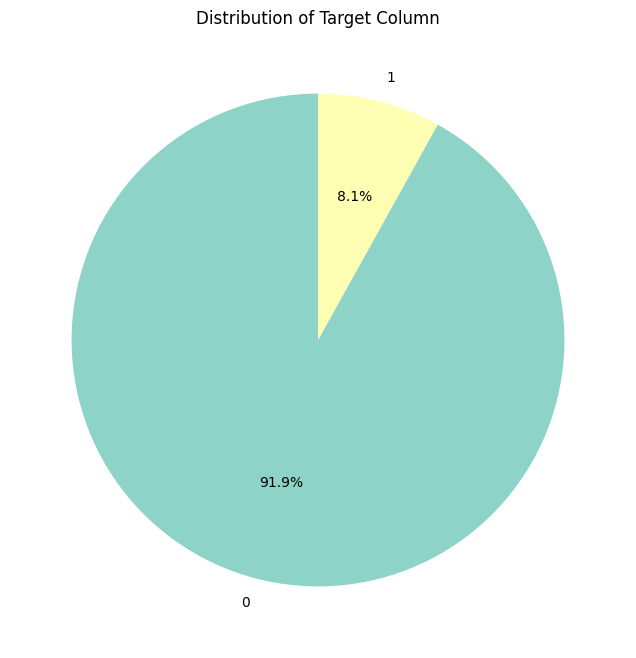

In [25]:
counts_in_Target_column = df_train['TARGET'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(counts_in_Target_column, labels=counts_in_Target_column.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))
plt.title('Distribution of Target Column')
plt.show()

In [34]:
def plot_target_histograms(df, numerical_column, target_column='TARGET'):
    """
    Visualizes histograms of a numerical column, separated by the target column.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    numerical_column (str): The name of the numerical column to plot.
    target_column (str): The name of the target column (default is 'TARGET').
    """
    df[numerical_column] = df[numerical_column].astype('float32')

    # Split the data into two groups based on the target column
    target_0 = df[df[target_column] == 0]
    target_1 = df[df[target_column] == 1]

    # Set up the matplotlib figure
    plt.figure(figsize=(14, 10))

    # Plot histogram for target = 0
    plt.figure(figsize=(10,3))
    sns.histplot(target_0[numerical_column],kde=True, color='orange', alpha=0.5, label=f'{target_column} = 0')
    
    # Plot histogram for target = 1
    sns.histplot(target_1[numerical_column],kde=True, color='blue', alpha=0.5 ,label=f'{target_column} = 1')
    
    plt.title(f'Histogram of {numerical_column}')
    plt.xlabel(numerical_column)
    plt.ylabel('Frequency')
    
    plt.legend()
    plt.show()

In [35]:
numerical_df = df_train.select_dtypes(include=['number'])

binary_columns = [col for col in numerical_df.columns if numerical_df[col].nunique() == 2]

non_binary_numerical_columns = [col for col in numerical_df.columns if col not in binary_columns]

print(non_binary_numerical_columns)

['SK_ID_CURR', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATI

<Figure size 1400x1000 with 0 Axes>

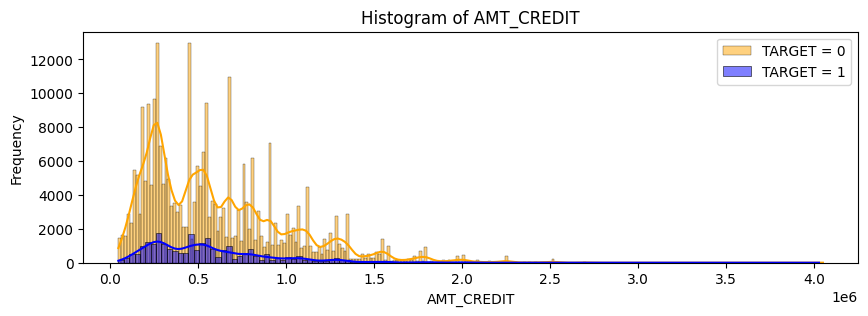

In [36]:
# Distribtion of AMT_CREDIT
plot_target_histograms(df_train, "AMT_CREDIT")

<Figure size 1400x1000 with 0 Axes>

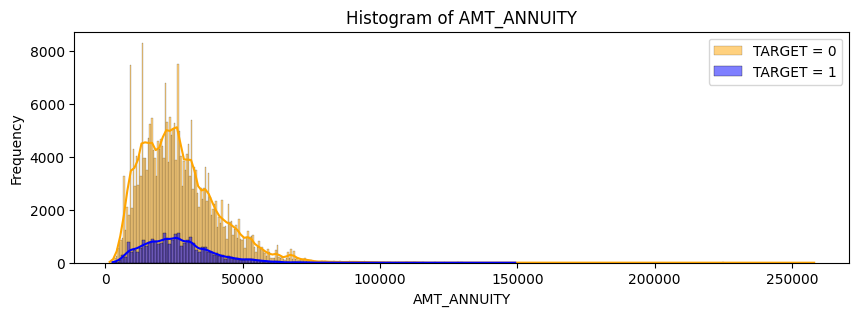

In [37]:
plot_target_histograms(df_train, "AMT_ANNUITY")


<Figure size 1400x1000 with 0 Axes>

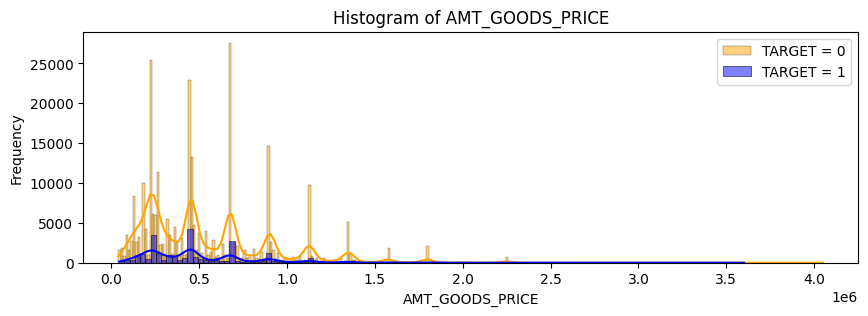

In [38]:
plot_target_histograms(df_train, "AMT_GOODS_PRICE")

<Figure size 1400x1000 with 0 Axes>

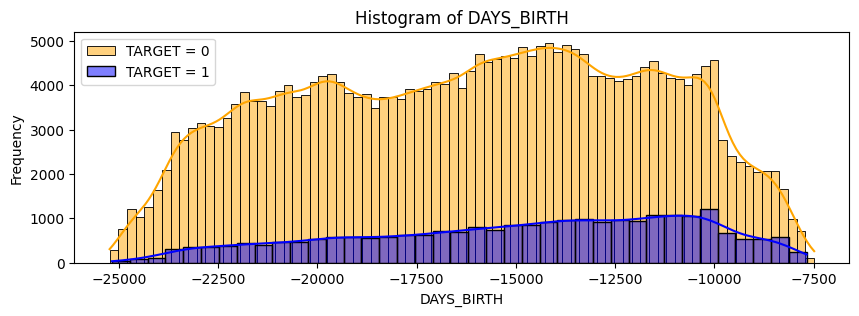

In [39]:
plot_target_histograms(df_train, "DAYS_BIRTH")

/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_7310/328700835.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["age_years"]=df_train["DAYS_BIRTH"]/-365


<Figure size 1400x1000 with 0 Axes>

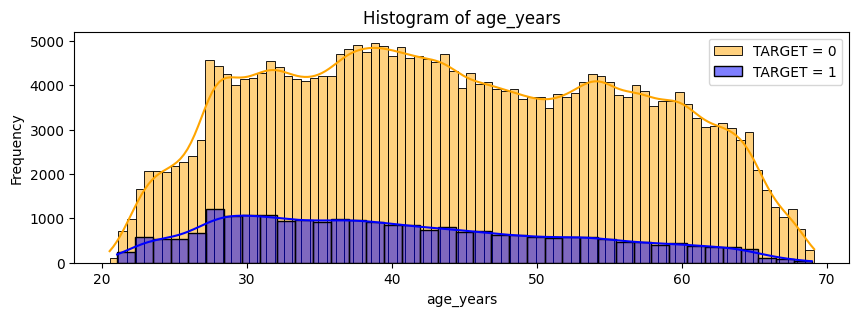

In [40]:
df_train["age_years"]=df_train["DAYS_BIRTH"]/-365
plot_target_histograms(df_train, "age_years")

<Figure size 1400x1000 with 0 Axes>

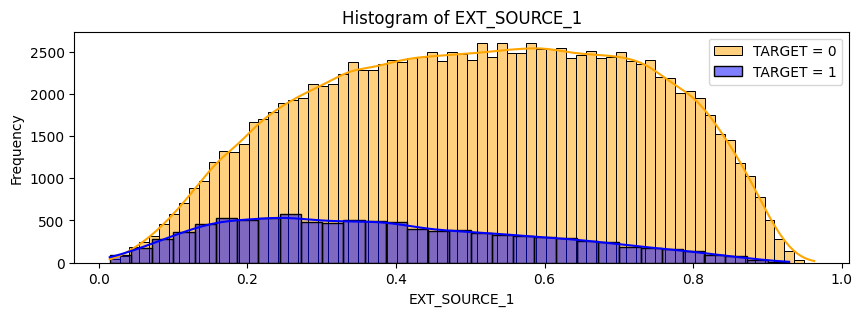

In [41]:
plot_target_histograms(df_train, "EXT_SOURCE_1")

<Figure size 1400x1000 with 0 Axes>

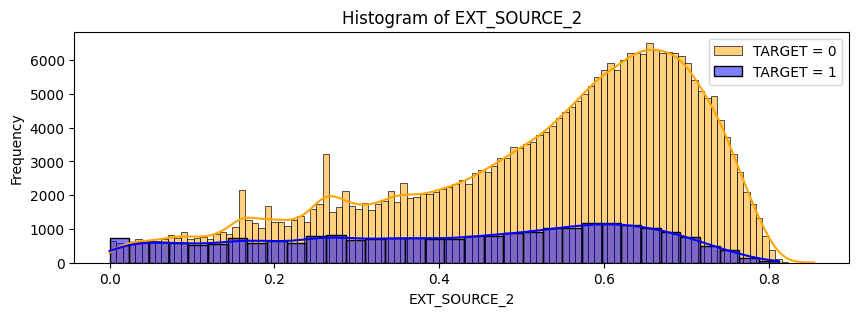

In [42]:
plot_target_histograms(df_train, "EXT_SOURCE_2")

<Figure size 1400x1000 with 0 Axes>

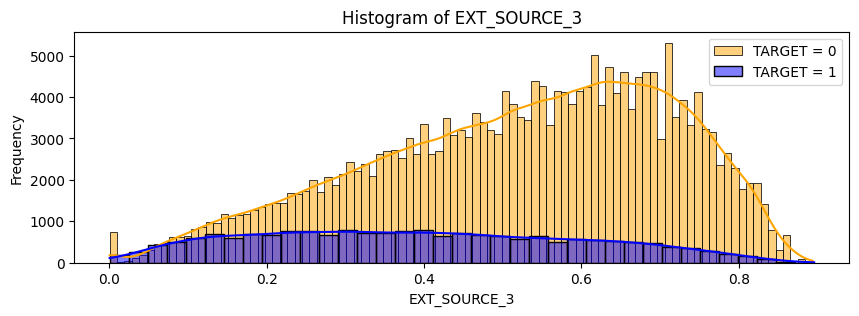

In [43]:
plot_target_histograms(df_train, "EXT_SOURCE_3")


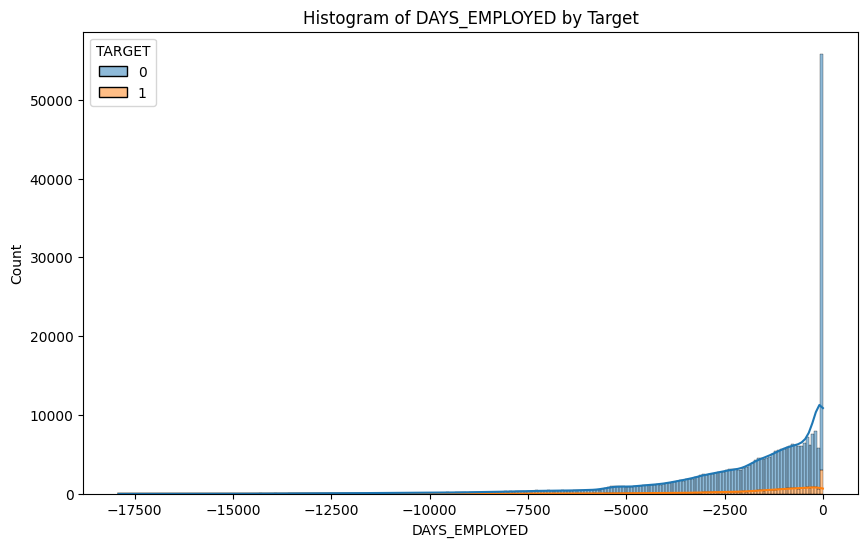

In [44]:
column_name = 'DAYS_EMPLOYED'
df_train.loc[df_train[column_name] > 0, column_name] = 0

plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x="DAYS_EMPLOYED", hue='TARGET', multiple='stack', kde=True)
plt.title(f'Histogram of DAYS_EMPLOYED by Target')
plt.xlabel("DAYS_EMPLOYED")
plt.ylabel('Count')
plt.show()

/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_7310/2285977144.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["DAYS_EMPLOYED_Years"]=df_train["DAYS_EMPLOYED"]/-365


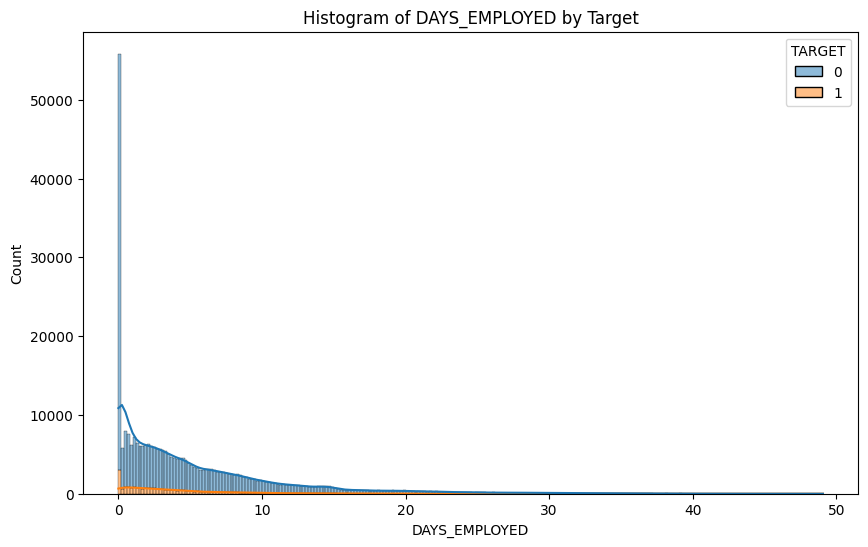

In [45]:
df_train["DAYS_EMPLOYED_Years"]=df_train["DAYS_EMPLOYED"]/-365
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train, x="DAYS_EMPLOYED_Years", hue='TARGET', multiple='stack', kde=True)
plt.title(f'Histogram of DAYS_EMPLOYED by Target')
plt.xlabel("DAYS_EMPLOYED")
plt.ylabel('Count')
plt.show()

/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_7310/4167843311.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["YEARS_REGISTRATION"]=df_train["DAYS_REGISTRATION"] / -365


<Figure size 1400x1000 with 0 Axes>

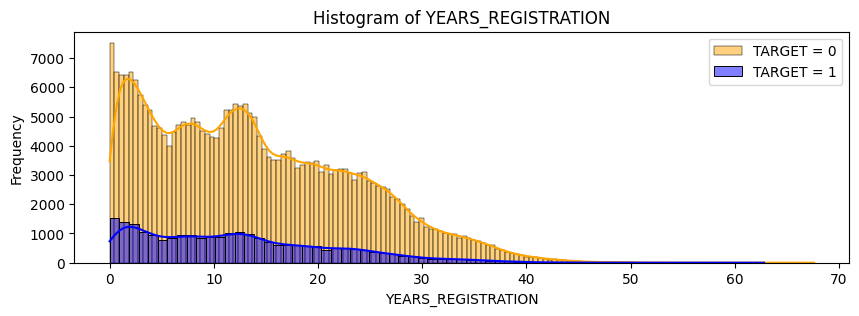

In [46]:
df_train["YEARS_REGISTRATION"]=df_train["DAYS_REGISTRATION"] / -365
plot_target_histograms(df_train, "YEARS_REGISTRATION")

In [47]:
categorical_columns = df_train.select_dtypes(include=['object',"category"]).columns.tolist()+[col for col in df_train.columns if df_train[col].nunique() == 2 and df_train[col].isin([0, 1]).all()]
categorical_columns

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'TARGET',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCU

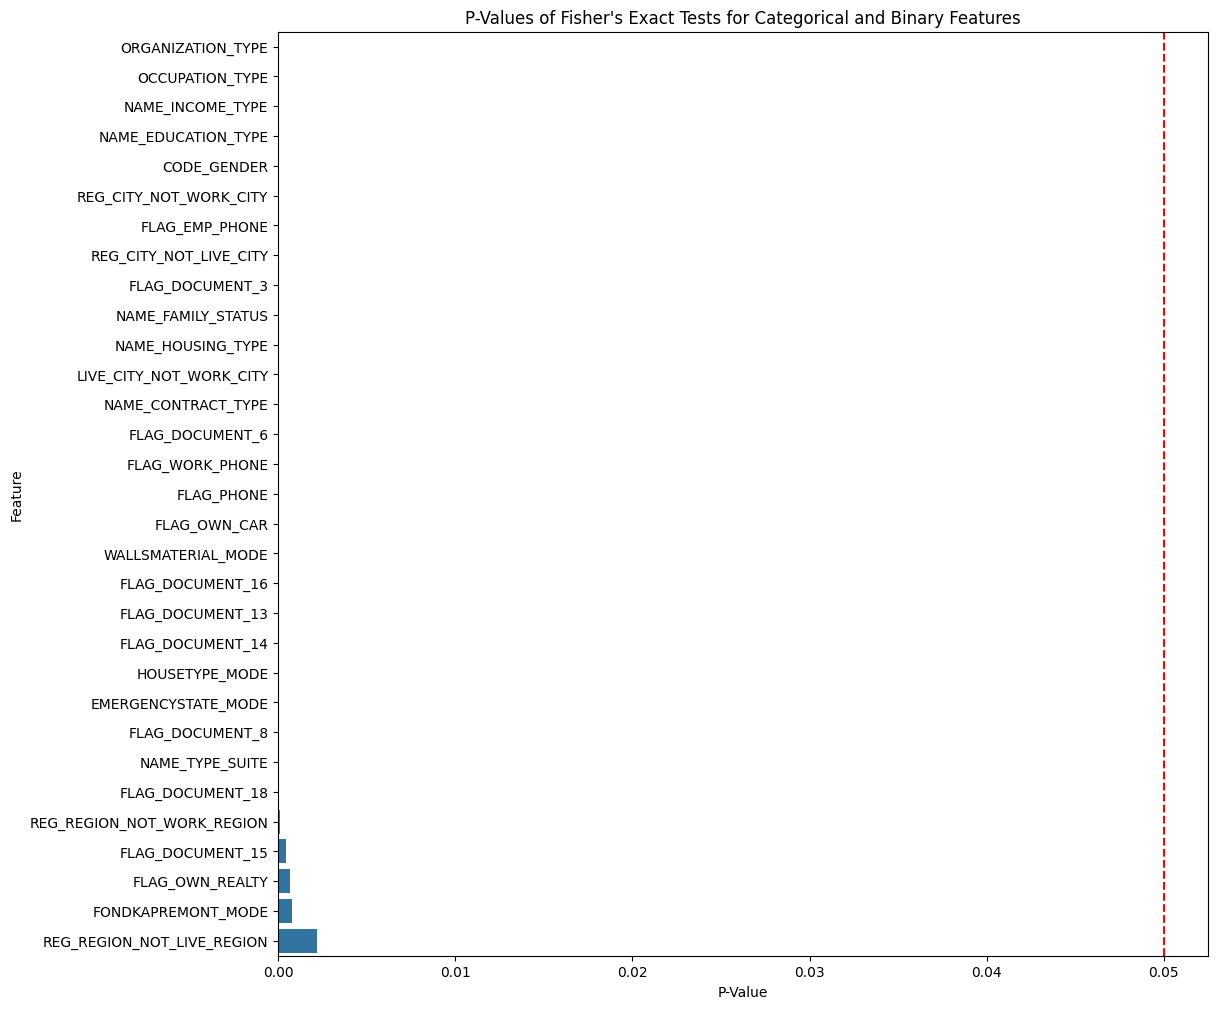

In [49]:
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency

categorical_columns = df_train.select_dtypes(include=['object']).columns.tolist()

# Identify columns with only 0 or 1 values
binary_columns = [col for col in df_train.columns if df_train[col].nunique() == 2 and df_train[col].isin([0, 1]).all()]

# Combine both lists
relevant_columns = categorical_columns + binary_columns
relevant_columns.remove("TARGET")
# Store the results
chi2_results = []

for column in relevant_columns:
    # Create a contingency table
    contingency_table = pd.crosstab(df_train[column], df_train['TARGET'])

    # Perform Chi-Square test
    chi2, p, _, _ = chi2_contingency(contingency_table)

    # Store the results
    chi2_results.append((column, chi2, p))

# Create a DataFrame for the results
chi2_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi2', 'p-value'])

# Sort by p-value
chi2_df = chi2_df.sort_values(by='p-value')


# Filter features with significant p-value (e.g., p < 0.05)
significant_features = chi2_df[chi2_df['p-value'] < 0.01]
plt.figure(figsize=(12, 12))
sns.barplot(x='p-value', y='Feature', data=significant_features)
plt.axvline(x=0.05, color='red', linestyle='--')  # Add a red line for the 0.05 significance level
plt.title('P-Values of Fisher\'s Exact Tests for Categorical and Binary Features')
plt.xlabel('P-Value')
plt.ylabel('Feature')
plt.show()

In [50]:
def catagorical_variables_target_relation(data, col1, col2='TARGET'):
    
    """
    Visualizes the relationship between a categorical variable and the target variable.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    col1 (str): The name of the categorical column.
    col2 (str): The name of the target column (default is 'TARGET').

    Returns:
    None
    """
    # Count number of zeros in dataframe 
    temp = pd.DataFrame(data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(data.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Percent_not_repaying_loan'] = pd.DataFrame(data.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)    
    temp=temp.head()
    ind = np.arange(temp.shape[0])

    plt.figure(figsize=(10, 6))
    p1 = plt.bar(ind, temp["total"].values,color='blue')
    p2 = plt.bar(ind, temp[col2].values,color='red')

    plt.ylabel('Loans')
    plt.title('Number of loans Repayed vs non repayed')
    plt.xticks(ticks=ind,rotation=90,labels= list(temp[col1].values))
    plt.legend((p1[0], p2[0]), ('0 Target', '1 Target'))
    plt.show()
    print(temp.head(5))

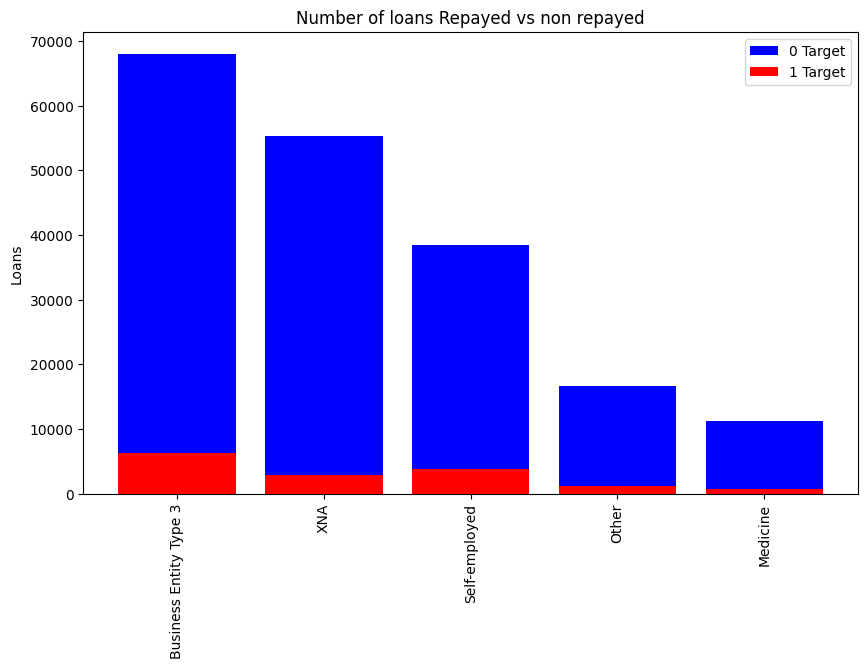

         ORGANIZATION_TYPE  TARGET  total  Percent_not_repaying_loan
5   Business Entity Type 3    6323  67992                   0.092996
57                     XNA    2990  55374                   0.053996
42           Self-employed    3908  38412                   0.101739
33                   Other    1275  16683                   0.076425
30                Medicine     737  11193                   0.065845


In [51]:
catagorical_variables_target_relation(df_train, "ORGANIZATION_TYPE", 'TARGET')

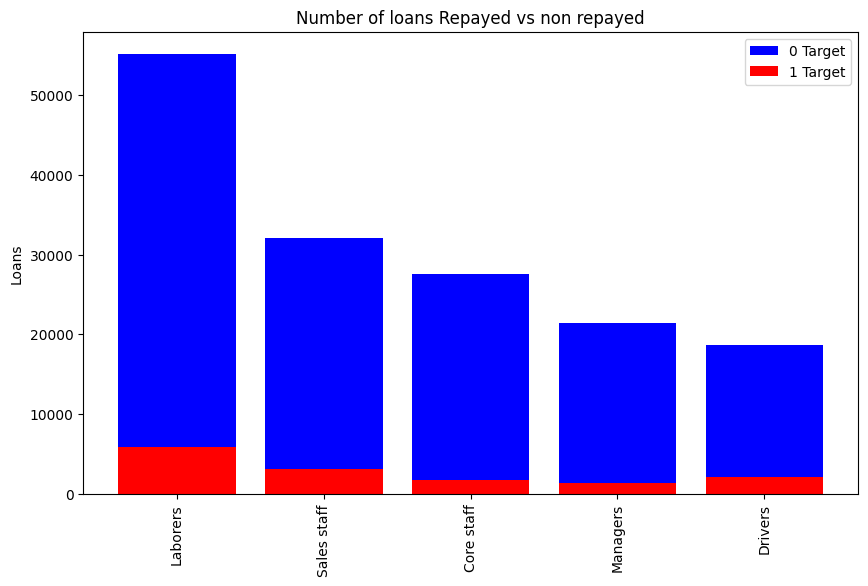

   OCCUPATION_TYPE  TARGET  total  Percent_not_repaying_loan
8         Laborers    5838  55186                   0.105788
14     Sales staff    3092  32102                   0.096318
3       Core staff    1738  27570                   0.063040
10        Managers    1328  21371                   0.062140
4          Drivers    2107  18603                   0.113261


In [52]:
catagorical_variables_target_relation(df_train, "OCCUPATION_TYPE", 'TARGET')

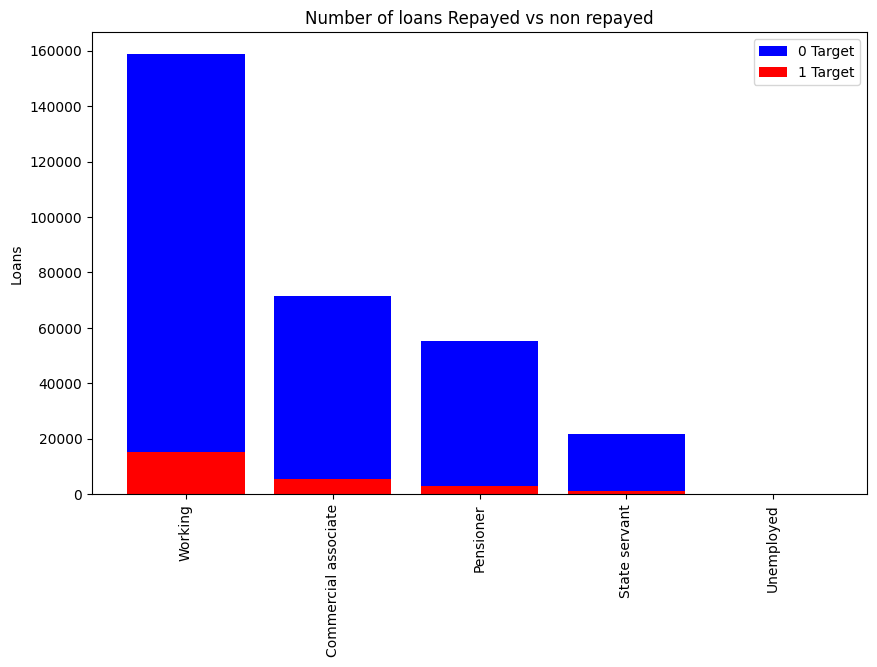

       NAME_INCOME_TYPE  TARGET   total  Percent_not_repaying_loan
7               Working   15224  158774                   0.095885
1  Commercial associate    5360   71617                   0.074843
3             Pensioner    2982   55362                   0.053864
4         State servant    1249   21703                   0.057550
6            Unemployed       8      22                   0.363636


In [53]:
catagorical_variables_target_relation(df_train, "NAME_INCOME_TYPE", 'TARGET')

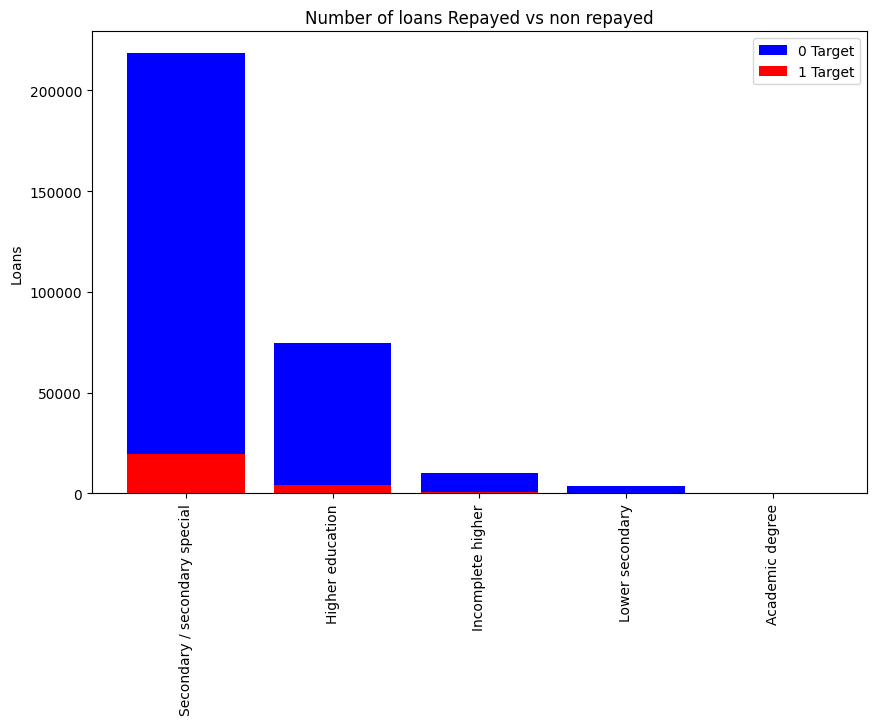

             NAME_EDUCATION_TYPE  TARGET   total  Percent_not_repaying_loan
4  Secondary / secondary special   19524  218391                   0.089399
1               Higher education    4009   74863                   0.053551
2              Incomplete higher     872   10277                   0.084850
3                Lower secondary     417    3816                   0.109277
0                Academic degree       3     164                   0.018293


In [54]:
catagorical_variables_target_relation(df_train, "NAME_EDUCATION_TYPE", 'TARGET')

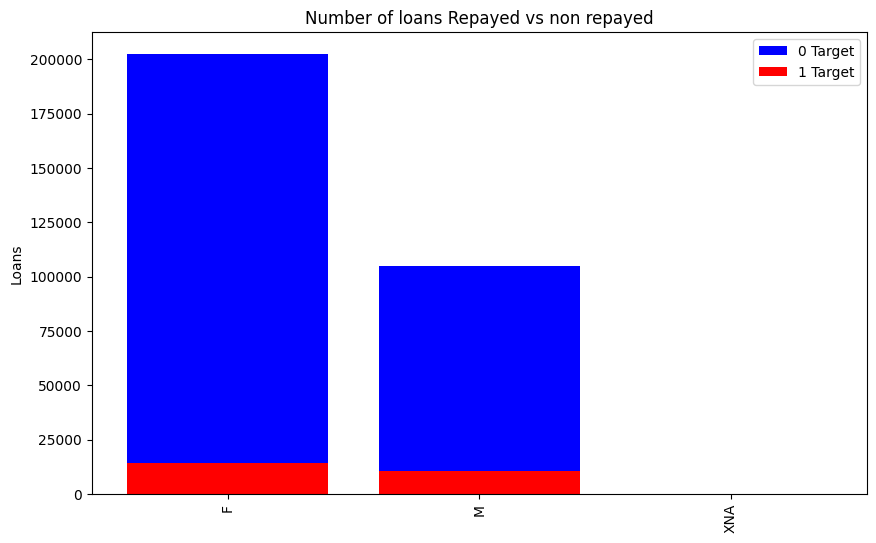

  CODE_GENDER  TARGET   total  Percent_not_repaying_loan
0           F   14170  202448                   0.069993
1           M   10655  105059                   0.101419
2         XNA       0       4                   0.000000


In [55]:
catagorical_variables_target_relation(df_train, "CODE_GENDER", 'TARGET')

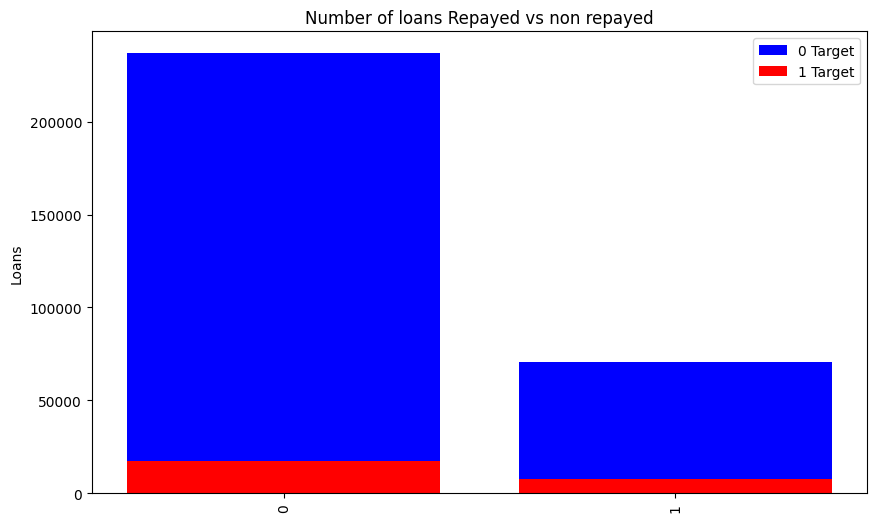

   REG_CITY_NOT_WORK_CITY  TARGET   total  Percent_not_repaying_loan
0                       0   17305  236644                   0.073127
1                       1    7520   70867                   0.106114


In [56]:
catagorical_variables_target_relation(df_train, "REG_CITY_NOT_WORK_CITY", 'TARGET')

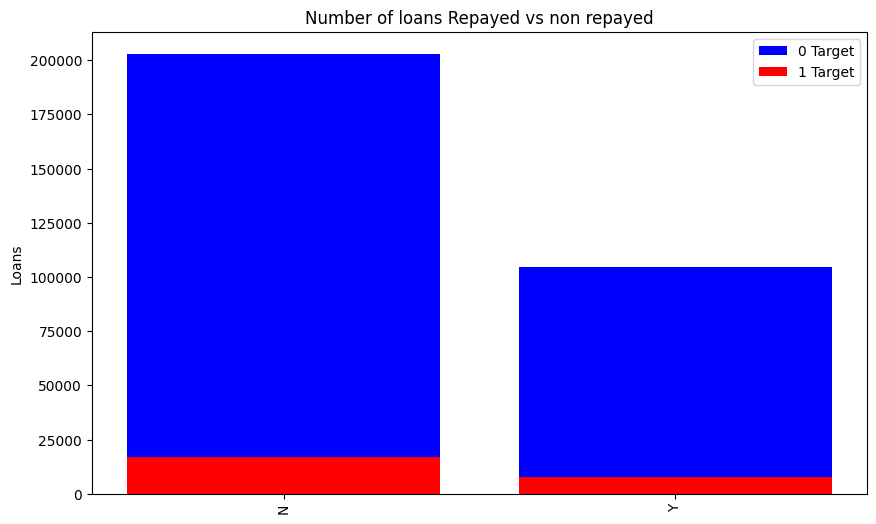

  FLAG_OWN_CAR  TARGET   total  Percent_not_repaying_loan
0            N   17249  202924                   0.085002
1            Y    7576  104587                   0.072437


In [57]:
catagorical_variables_target_relation(df_train, "FLAG_OWN_CAR", 'TARGET')

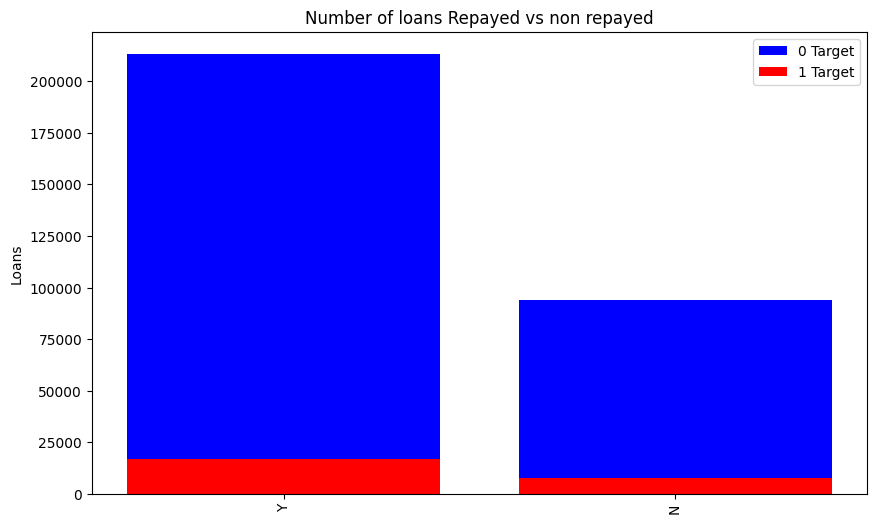

  FLAG_OWN_REALTY  TARGET   total  Percent_not_repaying_loan
1               Y   16983  213312                   0.079616
0               N    7842   94199                   0.083249


In [58]:
catagorical_variables_target_relation(df_train, "FLAG_OWN_REALTY", 'TARGET')

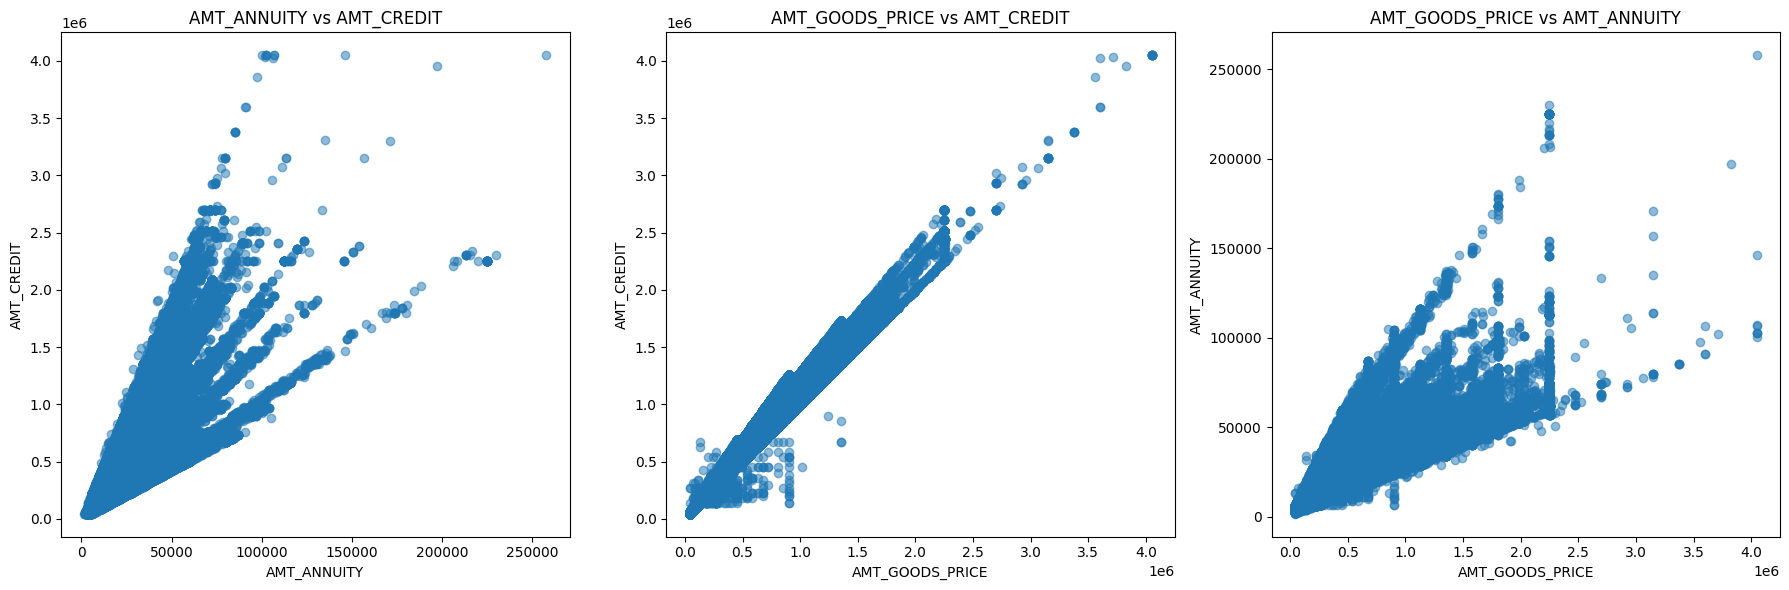

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# First scatter plot: AMT_ANNUITY vs AMT_CREDIT
axes[0].scatter(df_train["AMT_ANNUITY"], df_train["AMT_CREDIT"], alpha=0.5)
axes[0].set_title("AMT_ANNUITY vs AMT_CREDIT")
axes[0].set_xlabel("AMT_ANNUITY")
axes[0].set_ylabel("AMT_CREDIT")

# Second scatter plot: AMT_GOODS_PRICE vs AMT_CREDIT
axes[1].scatter(df_train["AMT_GOODS_PRICE"], df_train["AMT_CREDIT"], alpha=0.5)
axes[1].set_title("AMT_GOODS_PRICE vs AMT_CREDIT")
axes[1].set_xlabel("AMT_GOODS_PRICE")
axes[1].set_ylabel("AMT_CREDIT")

# Third scatter plot: AMT_GOODS_PRICE vs AMT_ANNUITY
axes[2].scatter(df_train["AMT_GOODS_PRICE"], df_train["AMT_ANNUITY"], alpha=0.5)
axes[2].set_title("AMT_GOODS_PRICE vs AMT_ANNUITY")
axes[2].set_xlabel("AMT_GOODS_PRICE")
axes[2].set_ylabel("AMT_ANNUITY")

plt.tight_layout()
plt.show()

In [60]:
def plot_box_with_two_categorical(df, numerical_column, cat_col1, cat_col2):
    """
    Creates a box plot of a numerical column with respect to two categorical columns.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    numerical_column (str): The name of the numerical column to plot.
    cat_col1 (str): The name of the first categorical column.
    cat_col2 (str): The name of the second categorical column.

    Returns:
    None
    """
    plt.figure(figsize=(14, 10))
    sns.boxplot(data=df, x=cat_col1, y=numerical_column, hue=cat_col2)
    plt.title(f'Box Plot of {numerical_column} with respect to {cat_col1} and {cat_col2}')
    plt.xlabel(cat_col1)
    plt.ylabel(numerical_column)
    plt.legend(title=cat_col2)
    plt.show()

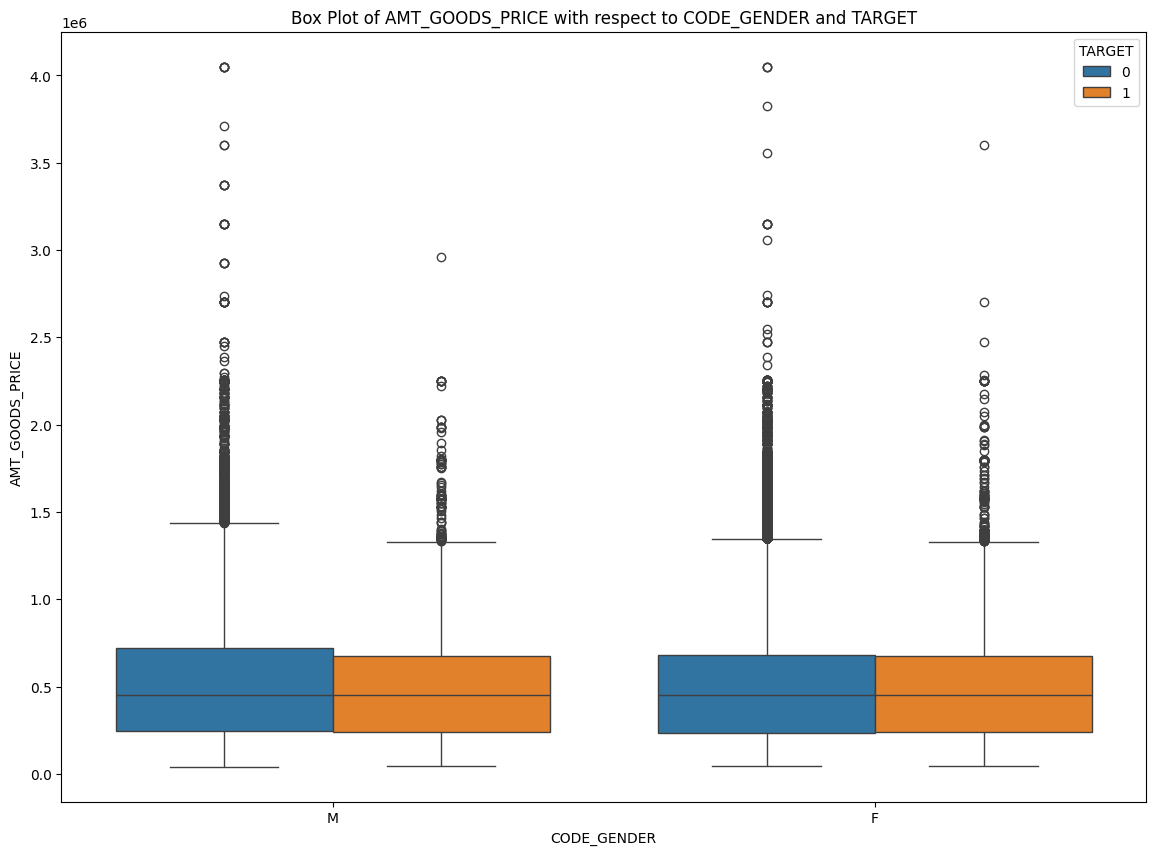

In [61]:
df_train["CODE_GENDER"]=df_train["CODE_GENDER"].str.replace("XNA","M")
plot_box_with_two_categorical(df_train, "AMT_GOODS_PRICE", "CODE_GENDER", "TARGET")

/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_7310/3002692701.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['AMT_INCOME_TOTAL_log'] = np.log(df_train['AMT_INCOME_TOTAL'] + 1)


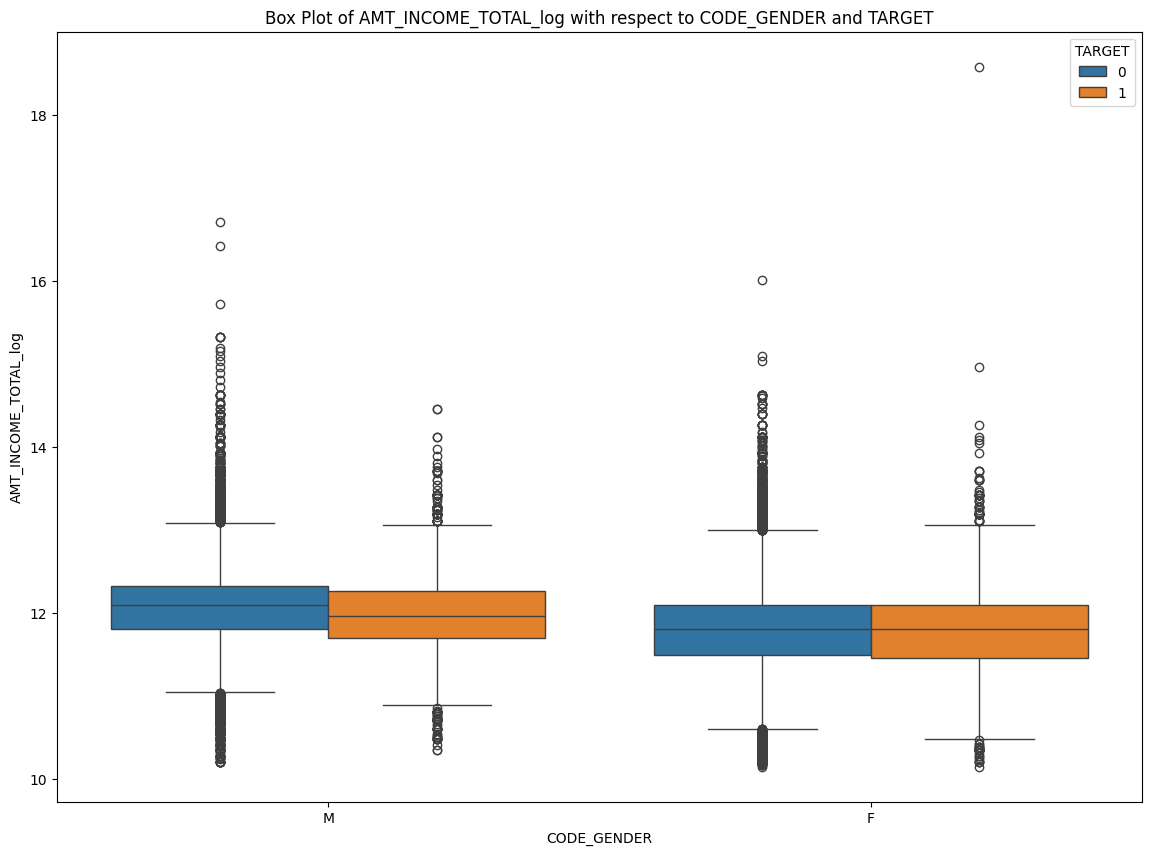

In [62]:
df_train['AMT_INCOME_TOTAL_log'] = np.log(df_train['AMT_INCOME_TOTAL'] + 1)
plot_box_with_two_categorical(df_train, "AMT_INCOME_TOTAL_log", "CODE_GENDER", "TARGET")

In [64]:
df_train['RATE_OF_LOAN'] = df_train['AMT_ANNUITY'] / df_train['AMT_CREDIT'].round(6)

df_train['AMT_INCOME_TOTAL'] = np.log(df_train['AMT_INCOME_TOTAL'] + 1)
df_train['AMT_CREDIT'] = np.log(df_train['AMT_CREDIT'] + 1)
df_train['AMT_ANNUITY'] = np.log(df_train['AMT_ANNUITY'] + 1)
df_train['AMT_GOODS_PRICE'] = np.log(df_train['AMT_GOODS_PRICE'] + 1)

df_train["AGE_YEARS"]=df_train["DAYS_BIRTH"]/-365
df_train["YEARS_EMPLOYED"]=df_train["DAYS_EMPLOYED"]/-365
df_train["YEARS_REGISTRATION"]=df_train["DAYS_REGISTRATION"] / -365

selected_columns = ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'FLAG_OWN_CAR','FLAG_OWN_REALTY',"NAME_INCOME_TYPE",
                    "REG_CITY_NOT_WORK_CITY",
                     'CNT_CHILDREN','AMT_INCOME_TOTAL', 'AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','AGE_YEARS',
                    'YEARS_EMPLOYED','YEARS_REGISTRATION',
                   'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',"RATE_OF_LOAN","TARGET"]

/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_7310/115879234.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["AGE_YEARS"]=df_train["DAYS_BIRTH"]/-365
/var/folders/fj/r2kb_f4d3k1gxmcwsdc81_1r0000gn/T/ipykernel_7310/115879234.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train["YEARS_EMPLOYED"]=df_train["DAYS_EMPLOYED"]/-365


In [65]:
len(selected_columns)

19

In [66]:
catagorical_columns=['CODE_GENDER',  'CNT_CHILDREN','NAME_EDUCATION_TYPE',  'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',"NAME_INCOME_TYPE","REG_CITY_NOT_WORK_CITY"]
numerical_columns = ['AMT_INCOME_TOTAL', 'AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','AGE_YEARS',
                    'YEARS_EMPLOYED','YEARS_REGISTRATION',
                   'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3',"RATE_OF_LOAN"]

In [67]:
len(catagorical_columns)+len(numerical_columns)

18

In [71]:
from imblearn.over_sampling import SMOTE

df_train_selected_column=df_train[selected_columns]
X = df_train_selected_column.drop(columns=["TARGET"])  
y = df_train_selected_column["TARGET"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

ValueError: could not convert string to float: 'M'

In [75]:
# Check if 'DAYS_EMPLOYED_Years' is in your DataFrame columns
print("Columns in df_train:", df_train.columns)

# Check if 'DAYS_EMPLOYED_Years' is in your numerical columns list
print("'DAYS_EMPLOYED_Years' in numerical_columns:", 'DAYS_EMPLOYED_Years' in numerical_columns)

Columns in df_train: Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'age_years', 'DAYS_EMPLOYED_Years',
       'YEARS_REGISTRATION', 'AMT_INCOME_TOTAL_log', 'RATE_OF_LOAN',
       'AGE_YEARS', 'YEARS_EMPLOYED'],
      dtype='object', length=129)
'DAYS_EMPLOYED_Years' in numerical_columns: True


In [81]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split


numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data: impute missing values with most frequent value (mode), then one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, catagorical_columns)
    ])
# Create a pipeline that first applies the preprocessing steps, then fits the random forest model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective='binary:logistic',eval_metric = 'auc',\
                         min_child_weight=10, max_depth=3, n_jobs=-1))
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  Index(['DAYS_EMPLOYED_Years', 'YEARS_EMPLOYED'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['CODE_GENDER',
                                                   'CNT_CHILDREN',
                                                   'NAME_EDUCATION_TYPE',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=None, ...))])

AUC: 0.6382513063026797
Precision: 0.22699386503067484
Recall: 0.029905031319458476


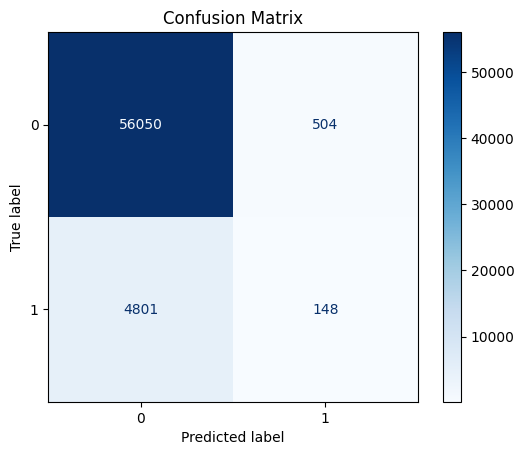

In [82]:
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Calculate the AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f'AUC: {auc}')
# Calculate precision and recall
threshold = 0.2
y_pred = (y_pred_prob >= threshold).astype(int)

precision = precision_score(y_test, y_pred, average='binary')  # Use 'macro', 'micro', or 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='binary')        # Use 'macro', 'micro', or 'weighted' for multi-class

# Print precision and recall
print(f'Precision: {precision}')
print(f'Recall: {recall}')

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.named_steps['classifier'].classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()